# Air Quality Analysis - San Francisco PM 2.5 May
1. Retrieve small particle data for San Francisco in May 2018,2019, & 2020.
2. Explore and compare data retreived from API vs. S3 storage.
3. Prepare data to be merged with existing Jan-Apr data.

## Collect Data (Options and Information)
Options for gathering data:
1. OpenAQ API
 - Access the most recent 90 days of data
 - Accessible via a URL Query
 - Documentation - https://docs.openaq.org/
2. OpenAQ AWS S3 Retention
 - Access full dataset
 - Accessible via query tool such as Amazon Athena, Apache Spark, or Google BigQuery
 - Documentation - https://gist.github.com/jflasher/573525aff9a5d8a966e5718272ceb25a
 - Medium Tutorial - https://medium.com/@openaq/how-in-the-world-do-you-access-air-quality-data-older-than-90-days-on-the-openaq-platform-8562df519ecd
3. EPA AirNow API
 - Documentation - https://docs.airnowapi.org/

### OpenAQ API (URL Query)
Since May2020 data is within the last 90 days, we could use the API with a URL query to access the measurments for San Francisco in the month of May. However, becasue 2018 and 2019 data is outside of this timeframe, we'll need to use a query tool to query OpenAQ's AWS S3 file storage. 

**URL Parameters & URL for San Francisco**  
City: San Francisco-Oakland-Fremont  
Location: San Francisco  
Parameter: 2.5  
Date: 2020-05-01 to 2020-05-31  
Format: csv  

Clicking the link below downloads a CSV file with the data we specified in the URL.  
https://api.openaq.org/v1/measurements?city=San%20Francisco-Oakland-Fremont&location=San%20Francisco&parameter=pm25&date_from=2020-05-01&date_to=2020-05-31&format=csv  

### OpenAQ AWS S3 Retention (Athena)
Additionally, we can query the entirety of the OpenAQ S3 "bucket". As per the instructions, we must:
1. Create an AWS account
2. Change to the optimal server **US East (N. Virginia)**
3. Create an S3 bucket and folder for our personal data storage.
4. Create a table for the OpenAQ data (example below)  
```python
CREATE EXTERNAL TABLE `openaq`(
  `date` struct<utc:string,local:string> COMMENT 'from deserializer', 
  `parameter` string COMMENT 'from deserializer', 
  `location` string COMMENT 'from deserializer', 
  `value` float COMMENT 'from deserializer', 
  `unit` string COMMENT 'from deserializer', 
  `city` string COMMENT 'from deserializer', 
  `attribution` array<struct<name:string,url:string>> COMMENT 'from deserializer', 
  `averagingperiod` struct<unit:string,value:float> COMMENT 'from deserializer', 
  `coordinates` struct<latitude:float,longitude:float> COMMENT 'from deserializer', 
  `country` string COMMENT 'from deserializer', 
  `sourcename` string COMMENT 'from deserializer', 
  `sourcetype` string COMMENT 'from deserializer', 
  `mobile` string COMMENT 'from deserializer')
ROW FORMAT SERDE 
  'org.openx.data.jsonserde.JsonSerDe' 
STORED AS INPUTFORMAT 
  'org.apache.hadoop.mapred.TextInputFormat' 
OUTPUTFORMAT 
  'org.apache.hadoop.hive.ql.io.HiveIgnoreKeyTextOutputFormat'
LOCATION
  's3://openaq-fetches/realtime-gzipped'
TBLPROPERTIES (
  'transient_lastDdlTime'='1518373755')
```
5. Run a SQL query to retreive data. (2018,2019,2020) (example below)
```python
SELECT *
FROM openaq
WHERE date.utc
    BETWEEN '2018-05-01'
        AND '2018-05-31'
        AND parameter = 'pm25'
        AND value >= 0
        AND location = 'San Francisco'
```

### EPA AirNow API
~ will do later ~

## Load & Explore Data with Python
**Dependencies**

In [1]:
import pandas as pd
## Code below changes the way code blocks are ran/displayed. Default behaviour is to only
## display the last code ran. Workarounds for this are to use the display() function for each item, 
## or this.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

**Import files with read.csv()**

In [2]:
df1 = pd.read_csv("SanFrancisco-May2020-OpenAQ_API.csv")
df2 = pd.read_csv("SanFrancisco-May2020-Athena_Query.csv")

Comparing the number of rows

In [3]:
f"API dataframe has {len(df1)} rows."
f"Query dataframe has {len(df2)} rows."

'API dataframe has 565 rows.'

'Query dataframe has 504 rows.'

Comparing the "head" of both dataframes

In [4]:
df1.head()
df2.head()

,location,city,country,utc,local,parameter,value,unit,latitude,longitude,attribution
0,San Francisco,San Francisco-Oakland-Fremont,US,2020-05-30T01:00:00.000Z,2020-05-29T17:00:00-08:00,pm25,2,µg/m³,37.7658,-122.3978,"[{""name"":""US EPA AirNow"",""url"":""http://www.air..."
1,San Francisco,San Francisco-Oakland-Fremont,US,2020-05-30T00:00:00.000Z,2020-05-29T16:00:00-08:00,pm25,3,µg/m³,37.7658,-122.3978,"[{""name"":""US EPA AirNow"",""url"":""http://www.air..."
2,San Francisco,San Francisco-Oakland-Fremont,US,2020-05-29T23:00:00.000Z,2020-05-29T15:00:00-08:00,pm25,3,µg/m³,37.7658,-122.3978,"[{""name"":""US EPA AirNow"",""url"":""http://www.air..."
3,San Francisco,San Francisco-Oakland-Fremont,US,2020-05-29T22:00:00.000Z,2020-05-29T14:00:00-08:00,pm25,4,µg/m³,37.7658,-122.3978,"[{""name"":""US EPA AirNow"",""url"":""http://www.air..."
4,San Francisco,San Francisco-Oakland-Fremont,US,2020-05-29T21:00:00.000Z,2020-05-29T13:00:00-08:00,pm25,3,µg/m³,37.7658,-122.3978,"[{""name"":""US EPA AirNow"",""url"":""http://www.air..."


,date,parameter,location,value,unit,city,attribution,averagingperiod,coordinates,country,sourcename,sourcetype,mobile
0,"{utc=2020-05-02T03:00:00.000Z, local=2020-05-0...",pm25,San Francisco,3,µg/m³,San Francisco-Oakland-Fremont,"[{name=US EPA AirNow, url=http://www.airnow.go...","{unit=hours, value=1.0}","{latitude=37.7658, longitude=-122.3978}",US,AirNow,government,False
1,"{utc=2020-05-04T04:00:00.000Z, local=2020-05-0...",pm25,San Francisco,5,µg/m³,San Francisco-Oakland-Fremont,"[{name=US EPA AirNow, url=http://www.airnow.go...","{unit=hours, value=1.0}","{latitude=37.7658, longitude=-122.3978}",US,AirNow,government,False
2,"{utc=2020-05-02T00:00:00.000Z, local=2020-05-0...",pm25,San Francisco,4,µg/m³,San Francisco-Oakland-Fremont,"[{name=US EPA AirNow, url=http://www.airnow.go...","{unit=hours, value=1.0}","{latitude=37.7658, longitude=-122.3978}",US,AirNow,government,False
3,"{utc=2020-05-03T04:00:00.000Z, local=2020-05-0...",pm25,San Francisco,2,µg/m³,San Francisco-Oakland-Fremont,"[{name=US EPA AirNow, url=http://www.airnow.go...","{unit=hours, value=1.0}","{latitude=37.7658, longitude=-122.3978}",US,AirNow,government,False
4,"{utc=2020-05-06T06:00:00.000Z, local=2020-05-0...",pm25,San Francisco,10,µg/m³,San Francisco-Oakland-Fremont,"[{name=US EPA AirNow, url=http://www.airnow.go...","{unit=hours, value=1.0}","{latitude=37.7658, longitude=-122.3978}",US,AirNow,government,False


## Clean/Prepare Data


~ will do later ~

# Air Quality Analysis - Seattle  
Air quality in Seattle area is regulated by the following federal, state, and local agencies.
 - U.S. EPA, https://www3.epa.gov/airquality/
 - Washington state ecology, https://ecology.wa.gov/Air-Climate/Air-quality
 - Puget Sound Clean Air Agency, https://pscleanair.gov/  
 
Relevant Dates regarding Covid-19 in the state of Washington.  
https://www.governor.wa.gov/office-governor/official-actions/proclamations
 - 02/29/2020 State of Emergency
 - 03/13/2020 Statewide School Closures, No gatherings over 250 
 - 03/16/2020 No onsite consumption of food or beverages in public venue, No gatherings over 50
 - 03/23/2020 "Stay Home Stay Healthy" Prohibits all people in Washington State from leaving their homes or participating in social, spiritual and recreational gatherings of any kind regardless of the number of participants.
 - 05/31/2020 Transition from "Stay Home, Stay Healthy" to "Safe Start, Stay Healthy" (phased reopening by county)
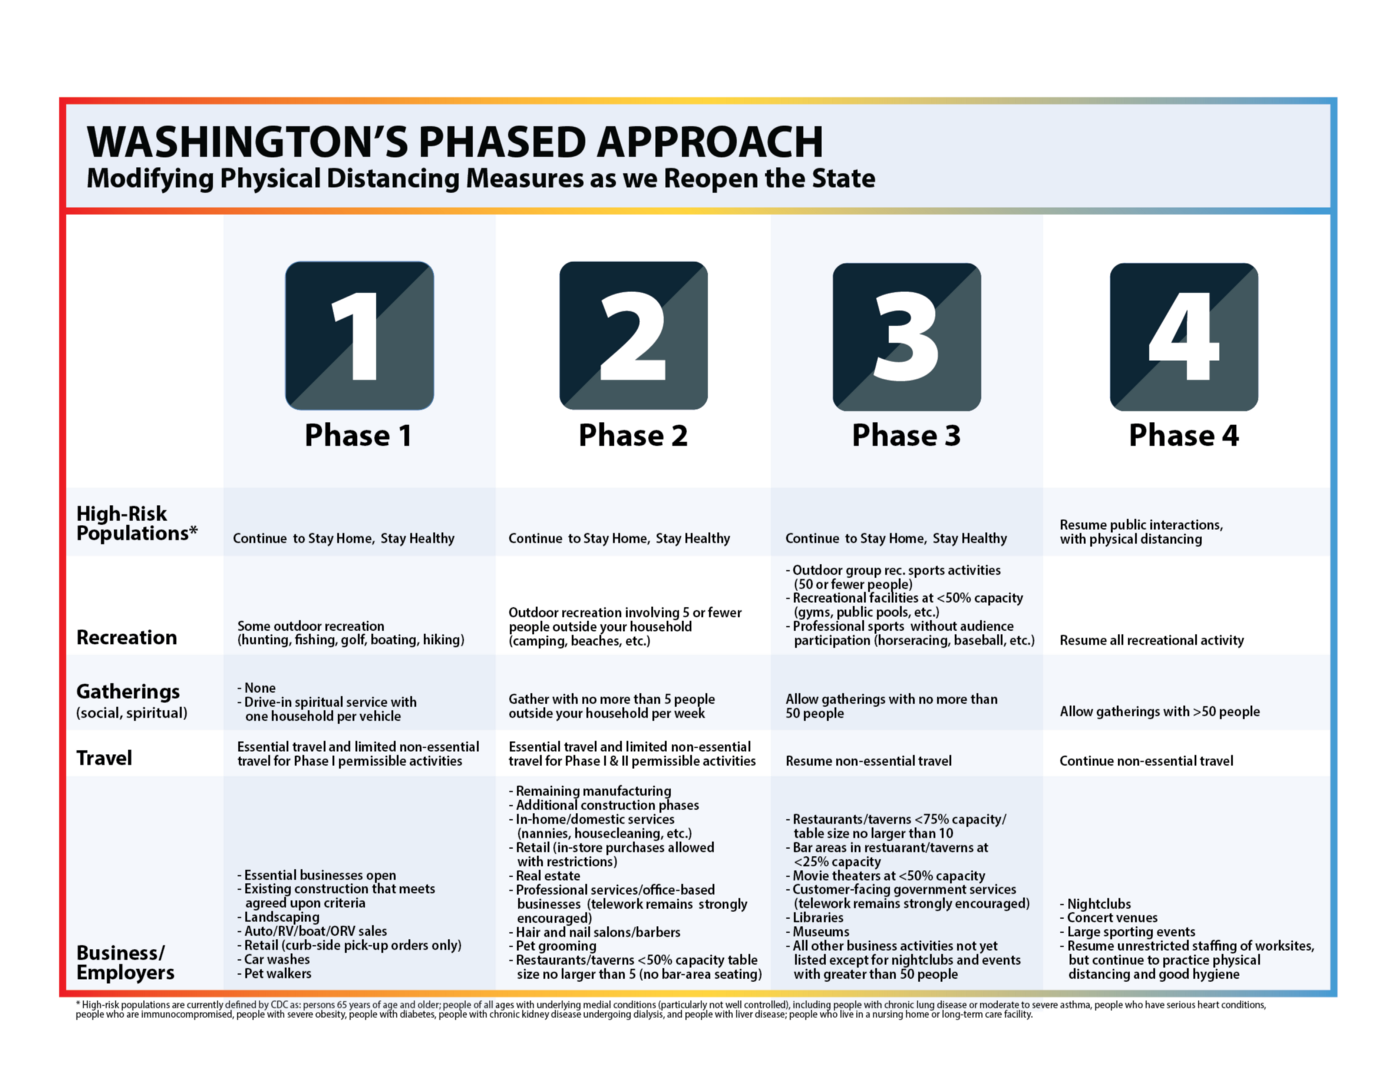

## Collect Data  
Again, we can use either SQL to query OpenAQ or the EPA AirNow API via a python script. For this data, I will attempt to use the AirNow API.

### EPA AirNow API
documentation - https://aqs.epa.gov/aqsweb/documents/data_api.html
Steps:
1. Sign up to obtain a key https://aqs.epa.gov/aqsweb/documents/data_api.html#signup (Make sure that you don't accidentially share your key when you share your code or upload it github)
2. Be aware of the API query limits! The EPA website limits query size to 1,000,000 rows per query. For frequency limits, the EPA says NO simultanious queries, 5 seconds between queries, and no more than 10 queries per minute.
3. Be aware of which parameters you will need to pass into the API to get the data you need. In this case, we needed to find codes for the "Seattle-Tacoma-Bellevue" area and for "fine particle" measurements. This required us to read the documentation, retreive lists of various parameters and codes, and then find the codes we need for our query within those lists. 

In [53]:
## Using the EPA AirNow API
"""
Goal: Extract Seattle air pollution measurement data from Jan 1st to May 31st 
for 2018,2019, & 2020. Also trying out different commenting styles in python ✌️
"""
## 1. We have a request size limit of 1,000,000 rows per query.
## 2. We don't know how many rows of data will be requested if we query for the data we want
## The EPA documentation suggests that we use the annual summary data to find out how many
## "observations" there are for the data we are seeking, so that we can adjust our query.

## Looking at the documentation, it appears that we can retreive annual summary data by
## Site, County, State, Box, and CBSA (Core Based Statistical Areas)
## Because of our goal to retreive data from Seattle, Site is too specific.
## County and State are probably more broad than we need. So it seems like we should pull
## either a "box" or CBSA that includes Seattle. 
## - The box is is contructed with min and max latitude and longitude values. 
## Since it might be hard to fit Seattle into a perfect box, let's see if any of the 
## CBSAs include Seattle, and if there is a way to filter for just Seattle with this data.

## How do we find out what CBSAs are availiable? We can return a list of CBSAs with the API!
## To return lists, we don't need to use our email and key, we can simply use "test"
## The documentation provides a link that will return what we're looking for. 
## Like everything the API will return, the list is in JSON format.

## Using python to query AirNow API for a list of CBSAs
'''
I want to practice python, so I'll be doing some extra stuff to retreive the values I want.
I will be using the popular requests package to 'get' the webpage data and decode the JSON format.
Then, I will navigate and search the key:value pairs to get the "code" we will need to query the 
CBSA for Seattle-Tacoma-Bellevue.

You could just open the link, ctrl+f, type Seattle, and get the code :D
'''

import requests

cbsa_list_url = 'https://aqs.epa.gov/data/api/list/cbsas?email=test@aqs.api&key=test'
r = requests.get(cbsa_list_url)
cbsa_list = r.json()
for row in cbsa_list["Data"]:
    for key, value in row.items():
        if "Seattle" in value:
            print(row)

{'code': '42660', 'value_represented': 'Seattle-Tacoma-Bellevue, WA'}


In [4]:
## The documentation shows us required and optional variables for each different type of query.
## annualData/byCBSA, the query we're trying to run to get the # of obvservations, so that we can 
## stay within our limits, requires the variables: email, key, param, bdate, edate, cbsa
## Since we have our email, key, beginning date, and end date, we just need the CBSA & param code

## As we found above, the "code" to access the Seattle-Tacoma-Bellevue CBSA is: 42660
## Since it will be easier to remember sea_code, lets assign the code to this variable.
sea_code = 42660

## Now that we have the CSBA code, we need to find the code for the "param" we want
## to know. This is used to specify, in the query, which data point or measurement we want. 
## For this project we are looking at the small particle levels. 
## Per the documentation, a list of parameter codes can be accessed by parameter classes.
## The list of parameter classes can be found by 
## Alternatively, a table of parameter classes and codes can be found here: 
## https://aqs.epa.gov/aqsweb/documents/codetables/parameter_classes.html
## The param code for small particle (PM2.5) is 88101
param_code = 88101

## Now that we have the CSBA code and the param code, we can query the annual summary to see
## how many observations there are. Remember, we're trying to figure out how many observations
## there are so that we can make sure we stay under the APIs limit.

## Using python and requests package to pull annual summary data for:
## Seattle-Tacoma-Bellevue area, small particle, from Jan 1st to May 31st
'''
Goal: Retreive the observation count for this area/time/particle measurement
'''

## Base URL for annualData/byCSBA: https://aqs.epa.gov/data/api/annualData/byCBSA?
annual_summary_url = 'https://aqs.epa.gov/data/api/annualData/byCBSA?'

## Now we just need to pass the correct parameters into the URL. We could type them in,
## or we could create a python script so that we can easily edit the variables and maybe
## pass lists of variables we want to query in the future. 

## Required Variables - email, key, param, bdate, edate, cbsa

import os

email = os.getenv("airnow_email")
key = os.getenv("airnow_key")
param = param_code
bdate = 20200101 ## YYYYMMDD format
edate = 20200531 ## So we begin with Jan 1st and end on May 31st
cbsa = sea_code

## The way parameters are typically used in URLs is with key:value pairs. The requests get()
## function will correctly pass a dictionary of key:value pairs into the URL as key=value.
## documentation for requests - https://requests.readthedocs.io/en/master/
parameters = {"email": email, "key": key, "param": param, 
              "bdate": bdate, "edate": edate, "cbsa": cbsa}

import requests
r = requests.get(annual_summary_url, parameters)
summary_data = r.json()
display(list(summary_data))

['Header', 'Data']

In [59]:
## Using the pandas package in python 
## to create a dataframe from the list of dictionaries labeled "Data".
import pandas as pd
df = pd.DataFrame.from_dict(summary_data["Data"])
df.to_csv("summary_data.csv")


In [63]:
observation_count = df['observation_count'].sum()
f"Observation count: {observation_count}"

'Observation count: 14966'

As expected, the observation count is well withing the 1,000,000 row query limit. However, I wanted to show the process for those that are expecting to query for much larger datasets, or for those working with an API with a lower size limit.  

Now, we will work on querying the data for the actual measurements/observations. 

In [84]:
## Using python to query sampleData/byCBSA
## required parameters - email, key, param, bdate, edate, cbsa
'''
Goal: Retreive sample data for Seattle-Tacoma-Bellevue area, Jan1st-May31st, PM2.5
'''

## Base URL for sampleData/byCBSA - https://aqs.epa.gov/data/api/sampleData/byCBSA?
sample_data_url = 'https://aqs.epa.gov/data/api/sampleData/byCBSA?'

## Required Variables - email, key, param, bdate, edate, cbsa
email = os.getenv("airnow_email")
key = os.getenv("airnow_key")
param = param_code
bdate = 20180101 ## YYYYMMDD format
edate = 20180531 ## So we begin with Jan 1st and end on May 31st
cbsa = sea_code

parameters = {"email": email, "key": key, "param": param, 
              "bdate": bdate, "edate": edate, "cbsa": cbsa}

r = requests.get(sample_data_url, parameters)
sample_data = r.json()

In [85]:
df_2018 = pd.DataFrame.from_dict(sample_data["Data"])
print(len(df_2018.index))
df_2018.to_csv("Sea-Tac-Bvu_2018_jan1-may31_pm25.csv")

32256


## Load & Explore Data

## Clean/Prepare Data